In [1]:
#Data saved in csv/excel
import glob, os
import pandas as pd

data_dir="C:/Users/TEMP/Box/Avera NIHTB Data"
os.chdir(data_dir)

# Compute the Total response time in minutes

In [2]:
# get all files from all RC In-person subdirectories

all_files = glob.glob('C:/Users/TEMP/Box/Avera NIHTB Data/Rapid City/*/In Person/*CB_Data.csv')

doc =[]
for file in all_files:
  data = pd.read_csv(file)
  doc.append(data)

# get all files from all SF
all_files = glob.glob('C:/Users/TEMP/Box/Avera NIHTB Data/Sioux Falls/*/In Person/*CB_Data.csv')
for file in all_files:
  data = pd.read_csv(file)
  doc.append(data)

all_files = glob.glob('C:/Users/TEMP/Box/Avera NIHTB Data/Sioux Falls/*/In Person/*PVT_Data.csv')
sep= []
for file in all_files:
  data = pd.read_csv(file)
  if data.shape[1]!= 11:
    print(data.shape)
    doc.append(data)

  else:
    sep.append(data)
    print(data.shape)
    print(file[42:])
df = pd.concat(doc)

(25, 23)
(26, 23)
(29, 23)
(403, 11)
alls\210409_EPSF_00943_A_9.5Y\In Person\210409_EPSF_00943_A_9.5Y_M_NT_NS_PVT_Data.csv
(25, 23)
(403, 11)
alls\210409_EPSF_00944_A_8Y\In Person\210409_EPSF_00944_A_M_NT_NS_PVT_Data.csv
(25, 23)
(403, 11)
alls\210409_EPSF_00944_B_8Y\In Person\210409_EPSF_00944_B_8Y_M_NT_NS_PVT_Data.csv
(25, 23)
(25, 23)
(25, 23)


In [3]:
sdf = pd.concat(sep)

In [4]:
sdf.shape

(1209, 11)

In [5]:
df.head()

,PIN,DeviceID,Assessment Name,InstOrdr,InstSctn,ItmOrdr,Inst,Locale,ItemID,Response,...,SE,DataType,Position,ResponseTime,DateCreated,InstStarted,InstEnded,App Version,iPad Version,Firmware Version
0,210330_EPRC_00032_A_8Y,DB9A19BF-F81C-4244-9C7F-D0BB4A39D394,Assessment 1,1,1,1,NIH Toolbox Picture Vocabulary Test Age 3+ Pra...,en-US,VOCAB_INTRO,NaN,...,NaN,informational,NaN,NaN,2021-03-30 09:43:19,2021-03-30 09:43:16,2021-03-30 09:44:46,1.23.4300,"iPad Pro 1st Gen (10.5-inch) / iPad7,3",14.4.1
1,210330_EPRC_00032_A_8Y,DB9A19BF-F81C-4244-9C7F-D0BB4A39D394,Assessment 1,1,1,2,NIH Toolbox Picture Vocabulary Test Age 3+ Pra...,en-US,VOCAB_INSTR1,NaN,...,NaN,informational,NaN,NaN,2021-03-30 09:44:10,2021-03-30 09:43:16,2021-03-30 09:44:46,1.23.4300,"iPad Pro 1st Gen (10.5-inch) / iPad7,3",14.4.1
2,210330_EPRC_00032_A_8Y,DB9A19BF-F81C-4244-9C7F-D0BB4A39D394,Assessment 1,1,1,3,NIH Toolbox Picture Vocabulary Test Age 3+ Pra...,en-US,VOCAB_PRACT1,4,...,NaN,integer,1.0,6.432752,2021-03-30 09:44:17,2021-03-30 09:43:16,2021-03-30 09:44:46,1.23.4300,"iPad Pro 1st Gen (10.5-inch) / iPad7,3",14.4.1
3,210330_EPRC_00032_A_8Y,DB9A19BF-F81C-4244-9C7F-D0BB4A39D394,Assessment 1,1,1,4,NIH Toolbox Picture Vocabulary Test Age 3+ Pra...,en-US,VOCAB_PRACT2,3,...,NaN,integer,2.0,6.050304,2021-03-30 09:44:24,2021-03-30 09:43:16,2021-03-30 09:44:46,1.23.4300,"iPad Pro 1st Gen (10.5-inch) / iPad7,3",14.4.1
4,210330_EPRC_00032_A_8Y,DB9A19BF-F81C-4244-9C7F-D0BB4A39D394,Assessment 1,1,1,5,NIH Toolbox Picture Vocabulary Test Age 3+ Pra...,en-US,VOCAB_INSTR2,NaN,...,NaN,informational,NaN,NaN,2021-03-30 09:44:46,2021-03-30 09:43:16,2021-03-30 09:44:46,1.23.4300,"iPad Pro 1st Gen (10.5-inch) / iPad7,3",14.4.1


In [6]:
df.columns

Index(['PIN', 'DeviceID', 'Assessment Name', 'InstOrdr', 'InstSctn', 'ItmOrdr',
       'Inst', 'Locale', 'ItemID', 'Response', 'Score', 'Theta', 'TScore',
       'SE', 'DataType', 'Position', 'ResponseTime', 'DateCreated',
       'InstStarted', 'InstEnded', 'App Version', 'iPad Version',
       'Firmware Version'],
      dtype='object')

In [7]:
#Reshape the data for EPSF_00944 and EPSF_00943 from long to wide
sdf=sdf.pivot_table(index=['PIN', 'DeviceID', 'AssessmentName', 'ResponseID', 'ItemID',
       'InstrumentTitle', 'TestName', 'InstrumentID'], columns='Key', values='Value', aggfunc='first').reset_index()

In [8]:
sdf.columns=['PIN', 'DeviceID', 'Assessment Name', 'ResponseID', 'ItemID',
       'Inst', 'TestName', 'InstrumentID', 'App Version', 'DataType',
       'DateCreated', 'Firmware Version', 'InstEnded',
      'InstOrdr', 'InstSctn', 'InstStarted',
       'ItmOrdr', 'Locale', 'Position', 'Response', 'ResponseTime', 'SE',
       'Score', 'Theta', 'iPad Version']

In [9]:
sdf =sdf.drop(columns=['ResponseID','TestName','InstrumentID'])

In [10]:
sdf['Site'] = 'Sioux Falls'

In [11]:
df = df.append(sdf)

In [12]:
df.shape

(2983, 24)

In [13]:
df['PIN'] = df['PIN'].str[7:17]

In [14]:
df['InstStarted']= pd.to_datetime(df['InstStarted'])

In [15]:
df['InstEnded']= pd.to_datetime(df['InstEnded'])

In [16]:
mni =df.groupby(['PIN','Inst'])['InstStarted','InstEnded'].first().reset_index()

<ipython-input-16-d7dc69386f29>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mni =df.groupby(['PIN','Inst'])['InstStarted','InstEnded'].first().reset_index()


In [17]:
mni['Time']=mni['InstEnded']-mni['InstStarted']

In [18]:
mni=mni.drop(columns=['InstStarted'])

In [19]:
mni.shape

(114, 4)

In [20]:
#drop 'NIH Toolbox List Sorting Working Memory Test Age 7+ v2.1' to calculate the time
mni_c=mni[mni['Inst']!='NIH Toolbox List Sorting Working Memory Test Age 7+ v2.1']

In [21]:
mni_c.shape

(102, 4)

In [22]:
#Using the corrected matched ones to calculate the time
IP =mni_c.groupby(['PIN'])['Time'].sum().reset_index()

In [23]:
IP['Time']=round(IP['Time'].dt.total_seconds()/60,2)

In [24]:
mni['Time']=round(mni['Time'].dt.total_seconds()/60,2)

In [25]:
mni['Mode'] = 'In Person'

In [26]:
mni.InstEnded= mni.InstEnded.map(lambda x: x.strftime('%Y-%m-%d'))

In [27]:
mni.rename(columns={'InstEnded':'Date'}, inplace=True)

In [28]:
mni

,PIN,Inst,Date,Time,Mode
0,EPRC_00032,NIH Toolbox Dimensional Change Card Sort Test ...,2021-03-30,5.30,In Person
1,EPRC_00032,NIH Toolbox Flanker Inhibitory Control and Att...,2021-03-30,3.97,In Person
2,EPRC_00032,NIH Toolbox List Sorting Working Memory Test A...,2021-03-30,10.60,In Person
3,EPRC_00032,NIH Toolbox Oral Reading Recognition Test Age ...,2021-03-30,1.43,In Person
4,EPRC_00032,NIH Toolbox Pattern Comparison Processing Spee...,2021-03-30,1.57,In Person
...,...,...,...,...,...
109,EPSF_01666,NIH Toolbox Pattern Comparison Processing Spee...,2021-04-12,1.82,In Person
110,EPSF_01666,NIH Toolbox Pattern Comparison Processing Spee...,2021-04-12,1.67,In Person
111,EPSF_01666,NIH Toolbox Picture Sequence Memory Test Age 8...,2021-04-12,6.47,In Person
112,EPSF_01666,NIH Toolbox Picture Vocabulary Test Age 3+ Pra...,2021-04-12,1.40,In Person


In [29]:
IP['Time'].mean()

21.707333333333334

In [30]:
# get all files from all RC Remote subdirectories

all_files = glob.glob('C:/Users/TEMP/Box/Avera NIHTB Data/Rapid City/*/Remote/*CB_Data_R.csv')


doc =[]
for file in all_files:
  data = pd.read_csv(file)
  doc.append(data)

# get all files from all SF Remote subdirectories
all_files = glob.glob('C:/Users/TEMP/Box/Avera NIHTB Data/Sioux Falls/*/Remote/*Data_R.csv')

for file in all_files:
  data = pd.read_csv(file)
  doc.append(data)

df = pd.concat(doc)

In [31]:
df.head()

,PIN,DeviceID,Assessment Name,InstOrdr,InstSctn,ItmOrdr,Inst,Locale,ItemID,Response,...,Race,Ethnicity,RegistrationID,ResponseID,AssessmentName,InstrumentTitle,TestName,InstrumentID,Key,Value
0,210406_EPRC_00032_A_8Y,4C0D4D8F-B79D-47C3-AF1A-4D100D11BF28,Assessment 1,1.0,1.0,1.0,NIH Toolbox Picture Vocabulary Test Age 3+ Pra...,en-US,VOCAB_INTRO,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,210406_EPRC_00032_A_8Y,4C0D4D8F-B79D-47C3-AF1A-4D100D11BF28,Assessment 1,1.0,1.0,2.0,NIH Toolbox Picture Vocabulary Test Age 3+ Pra...,en-US,VOCAB_INSTR1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,210406_EPRC_00032_A_8Y,4C0D4D8F-B79D-47C3-AF1A-4D100D11BF28,Assessment 1,1.0,1.0,3.0,NIH Toolbox Picture Vocabulary Test Age 3+ Pra...,en-US,VOCAB_PRACT1,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,210406_EPRC_00032_A_8Y,4C0D4D8F-B79D-47C3-AF1A-4D100D11BF28,Assessment 1,1.0,1.0,4.0,NIH Toolbox Picture Vocabulary Test Age 3+ Pra...,en-US,VOCAB_PRACT2,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,210406_EPRC_00032_A_8Y,4C0D4D8F-B79D-47C3-AF1A-4D100D11BF28,Assessment 1,1.0,1.0,5.0,NIH Toolbox Picture Vocabulary Test Age 3+ Pra...,en-US,VOCAB_INSTR2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
df['PIN']=df['PIN'].replace(' ', '', regex=True)

In [33]:
df['PIN'] = df['PIN'].str[7:17]

In [34]:
df['PIN'].unique()

array(['EPRC_00032', 'EPRC_00160', 'EPRC_00173', 'EPRC_00179',
       'EPRC_00181', 'EPRC_00183', 'EPRC_00191', 'EPRC_00380',
       'EPSF_00832', 'EPSF_01666', 'EPSF_00847', 'EPSF_00944',
       'EPSF_00836'], dtype=object)

In [35]:
df['InstStarted']= pd.to_datetime(df['InstStarted'])

In [36]:
df['InstEnded']= pd.to_datetime(df['InstEnded'])

In [37]:
mnr =df.groupby(['PIN','Inst'])['InstStarted','InstEnded'].first().reset_index()

<ipython-input-37-36cef9752c8c>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mnr =df.groupby(['PIN','Inst'])['InstStarted','InstEnded'].first().reset_index()


In [38]:
mnr['Time']=mnr['InstEnded']-mnr['InstStarted']

In [39]:
mnr=mnr.drop(columns=['InstStarted'])

In [40]:
mnr.InstEnded= mnr.InstEnded.map(lambda x: x.strftime('%Y-%m-%d'))

In [41]:
RM =mnr.groupby(['PIN'])['Time'].sum().reset_index()

In [42]:
RM['Time']=round(RM['Time'].dt.total_seconds()/60,2)

In [43]:
mnr.rename(columns={'InstEnded':'Date'}, inplace=True)

In [44]:
RM

,PIN,Time
0,EPRC_00032,27.20
1,EPRC_00160,31.40
2,EPRC_00179,27.92
3,EPRC_00181,27.35
4,EPRC_00183,23.12
5,EPRC_00191,28.25
6,EPRC_00380,27.92
7,EPSF_00832,26.47
8,EPSF_00836,27.62
9,EPSF_00847,25.82


In [45]:
RM['Time'].mean()

27.89166666666667

In [46]:
mnr['Time']=round(mnr['Time'].dt.total_seconds()/60,2)

In [47]:
mnr['Mode'] ='Remote'

# a. A matched t-test for those who have both in-person and remote - Total Time
There are only 8 students both have in person and remote

In [48]:
#drop the two outliers only have 2 inst for in person
IP=IP[IP['PIN']!='EPSF_00836']
IP=IP[IP['PIN']!='EPSF_00847']

In [49]:
times = pd.merge(IP, RM, how= 'inner', on='PIN')

In [50]:
times.columns =['PIN','Total_time', 'Total_time_R']

In [51]:
times

,PIN,Total_time,Total_time_R
0,EPRC_00032,25.73,27.20
1,EPRC_00160,25.63,31.40
2,EPRC_00179,21.40,27.92
3,EPRC_00181,24.33,27.35
4,EPRC_00380,24.33,27.92
5,EPSF_00832,23.53,26.47
6,EPSF_00944,34.43,34.08
7,EPSF_01666,25.17,27.55


In [52]:
IP.PIN.unique()

array(['EPRC_00032', 'EPRC_00160', 'EPRC_00162', 'EPRC_00173',
       'EPRC_00179', 'EPRC_00181', 'EPRC_00380', 'EPRC_00550',
       'EPSF_00832', 'EPSF_00943', 'EPSF_00944', 'EPSF_01247',
       'EPSF_01666'], dtype=object)

In [53]:
RM.PIN.unique()

array(['EPRC_00032', 'EPRC_00160', 'EPRC_00179', 'EPRC_00181',
       'EPRC_00183', 'EPRC_00191', 'EPRC_00380', 'EPSF_00832',
       'EPSF_00836', 'EPSF_00847', 'EPSF_00944', 'EPSF_01666'],
      dtype=object)

In [54]:
import numpy as np
import scipy.stats as stats
print('t-statistic = %6.3f pvalue = %6.4f' % stats.ttest_ind(times.Total_time, times.Total_time_R, equal_var = False))

t-statistic = -1.928 pvalue = 0.0772


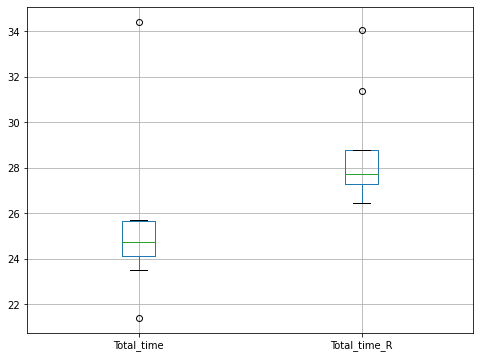

In [55]:
import matplotlib.pyplot as plt

# Box plot of ACS In person vs. Remote
plt.figure(figsize=(8, 6))
times.boxplot(column=['Total_time', 'Total_time_R'])

plt.show()

# b.	A student’s t-test for everyone 
15 has In-person, 12 has remote

In [56]:
print('t-statistic = %6.3f pvalue = %6.4f' % stats.ttest_ind(IP.Time, RM.Time, equal_var=False))

t-statistic = -1.513 pvalue = 0.1506


# c.	Correlations between remote and in-person- Total Time
There are only 8 students both have in person and remote

In [57]:
import numpy as np
import scipy.stats as stats

print('Correlation = %6.3f pvalue = %6.4f' % stats.pearsonr(times['Total_time'], times['Total_time_R']))    # Pearson's correlation coefficient and p-value 

Correlation =  0.832 pvalue = 0.0104


In [58]:
time_breakdown = pd.concat([mni,mnr]) 

In [59]:
time_breakdown.Inst.unique()

array(['NIH Toolbox Dimensional Change Card Sort Test Ages 8-11 v2.1',
       'NIH Toolbox Flanker Inhibitory Control and Attention Test Ages 8-11 v2.1',
       'NIH Toolbox List Sorting Working Memory Test Age 7+ v2.1',
       'NIH Toolbox Oral Reading Recognition Test Age 3+ v2.1',
       'NIH Toolbox Pattern Comparison Processing Speed Test Age 7+ Practice v2.1',
       'NIH Toolbox Pattern Comparison Processing Speed Test Age 7+ v2.1',
       'NIH Toolbox Picture Sequence Memory Test Age 8+ Form A v2.1',
       'NIH Toolbox Picture Vocabulary Test Age 3+ Practice v2.1',
       'NIH Toolbox Picture Vocabulary Test Age 3+ v2.1',
       'NIH Toolbox Picture Sequence Memory Test Age 8+ Form B v2.1'],
      dtype=object)

In [60]:
time_breakdown.groupby(['PIN','Mode'])['Inst'].count()

PIN         Mode     
EPRC_00032  In Person    9
            Remote       8
EPRC_00160  In Person    9
            Remote       8
EPRC_00162  In Person    9
EPRC_00173  In Person    9
EPRC_00179  In Person    9
            Remote       8
EPRC_00181  In Person    9
            Remote       8
EPRC_00183  Remote       6
EPRC_00191  Remote       8
EPRC_00380  In Person    9
            Remote       8
EPRC_00550  In Person    9
EPSF_00832  In Person    9
            Remote       8
EPSF_00836  In Person    2
            Remote       8
EPSF_00847  In Person    2
            Remote       8
EPSF_00943  In Person    2
EPSF_00944  In Person    9
            Remote       8
EPSF_01247  In Person    9
EPSF_01666  In Person    9
            Remote       7
Name: Inst, dtype: int64

# d.	Does it take longer for remote vs. in-person? - Total Time


In [61]:
print('t-statistic = %6.3f pvalue = %6.4f' % stats.wilcoxon(times.Total_time, times.Total_time_R, alternative='two-sided'))

t-statistic =  1.000 pvalue = 0.0156


In [62]:
times

,PIN,Total_time,Total_time_R
0,EPRC_00032,25.73,27.20
1,EPRC_00160,25.63,31.40
2,EPRC_00179,21.40,27.92
3,EPRC_00181,24.33,27.35
4,EPRC_00380,24.33,27.92
5,EPSF_00832,23.53,26.47
6,EPSF_00944,34.43,34.08
7,EPSF_01666,25.17,27.55


# e.	Plot on x-axis remote scores for all the Inst, and plot on y-axis all the in-person 

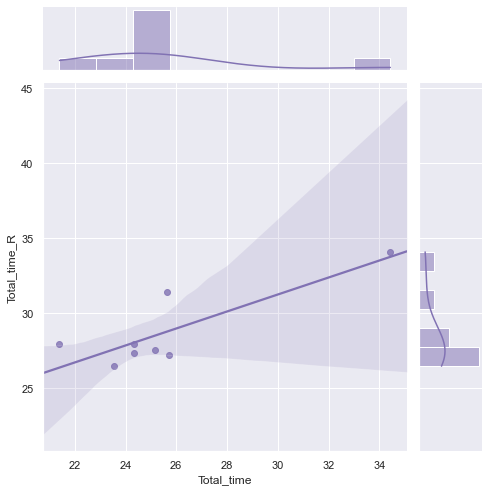

In [63]:
import seaborn as sns
sns.set_theme(style="darkgrid")

g = sns.jointplot(x="Total_time", y="Total_time_R", data=times,
                  kind="reg", truncate=False,
                  color="m", height=7)

# Scores

In [64]:
#  get all files from RC In-person subdirectories

all_files = glob.glob('C:/Users/TEMP/Box/Avera NIHTB Data//Rapid City/*/In Person/*CB_Scores.csv')


doc =[]
for file in all_files:
  data = pd.read_csv(file)
  doc.append(data)

# get all files from all SF In_person subdirectories
all_files = glob.glob('C:/Users/TEMP/Box/Avera NIHTB Data/Sioux Falls/*/In Person/*CB_Scores.csv')

for file in all_files:
  data = pd.read_csv(file)
  doc.append(data)

df = pd.concat(doc)

In [65]:
df.shape

(162, 28)

In [66]:
df['PIN'] = df['PIN'].str[7:17]

In [67]:
keep =['PIN', 'Inst', 'RawScore', 'Theta', 'SE',
       'ItmCnt', 'Computed Score',
       'Uncorrected Standard Score', 'Age-Corrected Standard Score',
       'National Percentile (age adjusted)', 'Fully-Corrected T-score',
       'InstrumentBreakoff', 'InstrumentStatus2']

In [68]:
df=df[keep]

In [69]:
times

,PIN,Total_time,Total_time_R
0,EPRC_00032,25.73,27.20
1,EPRC_00160,25.63,31.40
2,EPRC_00179,21.40,27.92
3,EPRC_00181,24.33,27.35
4,EPRC_00380,24.33,27.92
5,EPSF_00832,23.53,26.47
6,EPSF_00944,34.43,34.08
7,EPSF_01666,25.17,27.55


In [70]:
#Differentiate the rows contain Composites
comp =df[df['Inst'].str.contains("Composite")]
raw =df[~df['Inst'].str.contains("Composite")]

In [71]:
raw=raw.dropna(axis=1, how='all')
raw.head()

,PIN,Inst,RawScore,Theta,SE,ItmCnt,Computed Score,Uncorrected Standard Score,Age-Corrected Standard Score,National Percentile (age adjusted),Fully-Corrected T-score,InstrumentBreakoff,InstrumentStatus2
0,EPRC_00032,NIH Toolbox Picture Vocabulary Test Age 3+ v2.1,NaN,-2.411,0.475,20.0,NaN,71,95,36,36,2.0,3.0
1,EPRC_00032,NIH Toolbox Flanker Inhibitory Control and Att...,20.0,NaN,NaN,24.0,7.24,89,94,34,45,2.0,3.0
2,EPRC_00032,NIH Toolbox List Sorting Working Memory Test A...,16.0,NaN,NaN,15.0,NaN,97,108,69,48,2.0,3.0
3,EPRC_00032,NIH Toolbox Dimensional Change Card Sort Test ...,26.0,NaN,NaN,38.0,6.73,91,96,40,46,2.0,3.0
4,EPRC_00032,NIH Toolbox Pattern Comparison Processing Spee...,34.0,NaN,NaN,34.0,39.00,80,86,18,39,2.0,3.0


In [72]:
comp=comp.dropna(axis=1, how='all')
comp.head()

,PIN,Inst,Uncorrected Standard Score,Age-Corrected Standard Score,National Percentile (age adjusted),Fully-Corrected T-score
7,EPRC_00032,Cognition Fluid Composite v1.1,93,103,59,48
8,EPRC_00032,Cognition Crystallized Composite v1.1,71,85,16,32
9,EPRC_00032,Cognition Total Composite Score v1.1,78,93,32,38
10,EPRC_00032,Cognition Early Childhood Composite v1.1,89,105,62,48
7,EPRC_00160,Cognition Fluid Composite v1.1,94,109,73,49


In [73]:
comp.Inst.unique()

array(['Cognition Fluid Composite v1.1',
       'Cognition Crystallized Composite v1.1',
       'Cognition Total Composite Score v1.1',
       'Cognition Early Childhood Composite v1.1'], dtype=object)

In [74]:
df['Mode'] ='In Person'

In [75]:
#  get all files from RC Remote subdirectories

all_files = glob.glob('C:/Users/TEMP/Box/Avera NIHTB Data/Rapid City/*/Remote/*CB_Scores_R.csv')

doc =[]
for file in all_files:
  data = pd.read_csv(file)
  doc.append(data)


# get all files from all SF In_person subdirectories
all_files = glob.glob('C:/Users/TEMP/Box/Avera NIHTB Data/Sioux Falls/*/Remote/*CB_Scores_R.csv')

for file in all_files:
  data = pd.read_csv(file)
  doc.append(data)


dfr = pd.concat(doc)

In [76]:
dfr.shape

(102, 28)

In [77]:
dfr['PIN'] = dfr['PIN'].str[7:17]

In [78]:
dfr=dfr[keep]

In [79]:
dfr.head()

,PIN,Inst,RawScore,Theta,SE,ItmCnt,Computed Score,Uncorrected Standard Score,Age-Corrected Standard Score,National Percentile (age adjusted),Fully-Corrected T-score,InstrumentBreakoff,InstrumentStatus2
0,EPRC_00032,NIH Toolbox Picture Vocabulary Test Age 3+ v2.1,NaN,-1.730,0.482,24.0,NaN,74.0,95.0,36.0,44.0,2.0,3.0
1,EPRC_00032,NIH Toolbox Oral Reading Recognition Test Age ...,NaN,-4.995,0.500,22.0,NaN,78.0,80.0,10.0,34.0,2.0,3.0
2,EPRC_00032,NIH Toolbox Pattern Comparison Processing Spee...,34.0,NaN,NaN,37.0,39.00,80.0,86.0,18.0,39.0,2.0,3.0
3,EPRC_00032,NIH Toolbox Picture Sequence Memory Test Age 8...,19.0,0.238,0.310,6.0,585.56,115.0,121.0,92.0,62.0,2.0,3.0
4,EPRC_00032,NIH Toolbox Flanker Inhibitory Control and Att...,20.0,NaN,NaN,24.0,6.79,85.0,83.0,13.0,38.0,2.0,3.0


In [80]:
#Differentiate the rows contain Composites
comp_r =dfr[dfr['Inst'].str.contains("Composite")]
raw_r =dfr[~dfr['Inst'].str.contains("Composite")]

In [81]:
comp_r=comp_r.dropna(axis=1, how='all')
comp_r.head()

,PIN,Inst,Uncorrected Standard Score,Age-Corrected Standard Score,National Percentile (age adjusted),Fully-Corrected T-score
6,EPRC_00032,Cognition Crystallized Composite v1.1,74.0,85.0,16.0,38.0
7,EPRC_00032,Cognition Early Childhood Composite v1.1,85.0,98.0,44.0,43.0
6,EPRC_00160,Cognition Crystallized Composite v1.1,83.0,106.0,66.0,51.0
7,EPRC_00160,Cognition Early Childhood Composite v1.1,79.0,92.0,29.0,42.0
6,EPRC_00173,Cognition Crystallized Composite v1.1,63.0,72.0,3.0,39.0


In [82]:
comp['Mode'] = 'In Person'
comp_r['Mode'] = 'Remote'
boxp = pd.concat([comp,comp_r]) 

In [83]:
raw_r=raw_r.dropna(axis=1, how='all')
raw_r.head()

,PIN,Inst,RawScore,Theta,SE,ItmCnt,Computed Score,Uncorrected Standard Score,Age-Corrected Standard Score,National Percentile (age adjusted),Fully-Corrected T-score,InstrumentBreakoff,InstrumentStatus2
0,EPRC_00032,NIH Toolbox Picture Vocabulary Test Age 3+ v2.1,NaN,-1.730,0.482,24.0,NaN,74.0,95.0,36.0,44.0,2.0,3.0
1,EPRC_00032,NIH Toolbox Oral Reading Recognition Test Age ...,NaN,-4.995,0.500,22.0,NaN,78.0,80.0,10.0,34.0,2.0,3.0
2,EPRC_00032,NIH Toolbox Pattern Comparison Processing Spee...,34.0,NaN,NaN,37.0,39.00,80.0,86.0,18.0,39.0,2.0,3.0
3,EPRC_00032,NIH Toolbox Picture Sequence Memory Test Age 8...,19.0,0.238,0.310,6.0,585.56,115.0,121.0,92.0,62.0,2.0,3.0
4,EPRC_00032,NIH Toolbox Flanker Inhibitory Control and Att...,20.0,NaN,NaN,24.0,6.79,85.0,83.0,13.0,38.0,2.0,3.0


In [84]:
comp_r=comp_r.drop(columns='Mode')

In [85]:
comp=comp.drop(columns='Mode')

In [86]:
comp_r.columns =['PIN', 'Inst', 'Uncorrected Standard Score_r',
       'Age-Corrected Standard Score_r', 'National Percentile (age adjusted)_r',
       'Fully-Corrected T-score_r']

In [87]:
scores = pd.merge(comp, comp_r, on=["PIN",'Inst'])

In [88]:
dfr['Mode'] = 'Remote'

# NIH toolbox 

# a.	A matched t-test for those who have both in-person and remote 

In [89]:
raw['Mode'] = 'In Person'
raw_r['Mode'] = 'Remote'
boxr = pd.concat([raw,raw_r]) 

In [90]:
raw.columns

Index(['PIN', 'Inst', 'RawScore', 'Theta', 'SE', 'ItmCnt', 'Computed Score',
       'Uncorrected Standard Score', 'Age-Corrected Standard Score',
       'National Percentile (age adjusted)', 'Fully-Corrected T-score',
       'InstrumentBreakoff', 'InstrumentStatus2', 'Mode'],
      dtype='object')

In [91]:
keep1=['PIN', 'Inst', 'Age-Corrected Standard Score',
       'Fully-Corrected T-score']

In [92]:
raw=raw[keep1]
raw_r = raw_r[keep1]

In [93]:
raw_r.columns =['PIN', 'Inst', 'Age-Corrected Standard Score_r',
       'Fully-Corrected T-score_r']

In [94]:
NIH = pd.merge(raw, raw_r, on=["PIN",'Inst'])

In [95]:
NIH.head()

,PIN,Inst,Age-Corrected Standard Score,Fully-Corrected T-score,Age-Corrected Standard Score_r,Fully-Corrected T-score_r
0,EPRC_00032,NIH Toolbox Picture Vocabulary Test Age 3+ v2.1,95,36,95.0,44.0
1,EPRC_00032,NIH Toolbox Flanker Inhibitory Control and Att...,94,45,83.0,38.0
2,EPRC_00032,NIH Toolbox Dimensional Change Card Sort Test ...,96,46,96.0,39.0
3,EPRC_00032,NIH Toolbox Pattern Comparison Processing Spee...,86,39,86.0,39.0
4,EPRC_00032,NIH Toolbox Picture Sequence Memory Test Age 8...,128,67,121.0,62.0


In [96]:
boxr.Mode.value_counts()

In Person    104
Remote        79
Name: Mode, dtype: int64

In [97]:
boxr["Inst"].replace({'NIH Toolbox Picture Vocabulary Test Age 3+ v2.1':'Pic- Vocabulary ',
       'NIH Toolbox Flanker Inhibitory Control and Attention Test Ages 8-11 v2.1':'Flanker',
       'NIH Toolbox List Sorting Working Memory Test Age 7+ v2.1':'List Sorting',
       'NIH Toolbox Dimensional Change Card Sort Test Ages 8-11 v2.1':'Dimensional Change',
       'NIH Toolbox Pattern Comparison Processing Speed Test Age 7+ v2.1':'Pattern Comp',
       'NIH Toolbox Picture Sequence Memory Test Age 8+ Form A v2.1':'Pic Seq A',
       'NIH Toolbox Oral Reading Recognition Test Age 3+ v2.1':'Oral Reading',
       'NIH Toolbox Picture Sequence Memory Test Age 8+ Form B v2.1':'Pic Seq B',
       'NIH Toolbox Oral Reading Recognition Test Age 3+ Instructions v2.1':'Oral Reading Inst'}, inplace=True)

[Text(0, 0, 'Pic- Vocabulary '),
 Text(1, 0, 'Flanker'),
 Text(2, 0, 'List Sorting'),
 Text(3, 0, 'Dimensional Change'),
 Text(4, 0, 'Pattern Comp'),
 Text(5, 0, 'Pic Seq A'),
 Text(6, 0, 'Oral Reading'),
 Text(7, 0, 'Pic Seq B'),
 Text(8, 0, 'Oral Reading Inst')]

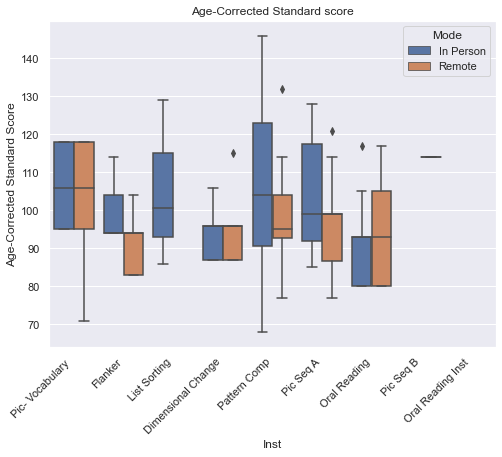

In [98]:
plt.figure(figsize=(8, 6))
chart =sns.boxplot(x = 'Inst', y = 'Age-Corrected Standard Score', hue='Mode',data = boxr)
plt.title('Age-Corrected Standard score')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')

[Text(0, 0, 'Pic- Vocabulary '),
 Text(1, 0, 'Flanker'),
 Text(2, 0, 'List Sorting'),
 Text(3, 0, 'Dimensional Change'),
 Text(4, 0, 'Pattern Comp'),
 Text(5, 0, 'Pic Seq A'),
 Text(6, 0, 'Oral Reading'),
 Text(7, 0, 'Pic Seq B'),
 Text(8, 0, 'Oral Reading Inst')]

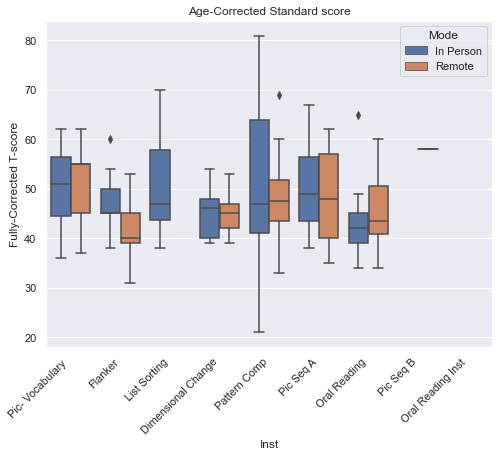

In [99]:
plt.figure(figsize=(8, 6))
chart =sns.boxplot(x = 'Inst', y = 'Fully-Corrected T-score', hue='Mode',data = boxr)
plt.title('Age-Corrected Standard score')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')

In [100]:
sb= NIH.set_index('Inst').filter(like='NIH Toolbox Picture Sequence Memory Test Age 8+ ', axis=0)
sb[['Age-Corrected Standard Score','Age-Corrected Standard Score_r']]

,Age-Corrected Standard Score,Age-Corrected Standard Score_r
Inst,,
NIH Toolbox Picture Sequence Memory Test Age 8+ Form A v2.1,128,121.0
NIH Toolbox Picture Sequence Memory Test Age 8+ Form A v2.1,121,92.0
NIH Toolbox Picture Sequence Memory Test Age 8+ Form A v2.1,99,NaN
NIH Toolbox Picture Sequence Memory Test Age 8+ Form A v2.1,114,NaN
NIH Toolbox Picture Sequence Memory Test Age 8+ Form A v2.1,92,99.0
NIH Toolbox Picture Sequence Memory Test Age 8+ Form A v2.1,92,77.0
NIH Toolbox Picture Sequence Memory Test Age 8+ Form A v2.1,106,77.0
NIH Toolbox Picture Sequence Memory Test Age 8+ Form A v2.1,92,77.0
NIH Toolbox Picture Sequence Memory Test Age 8+ Form A v2.1,121,99.0


In [107]:
def matched_ttest(data):
    match = list(data.Inst.unique())
    for minst in match:
        print('---',minst,'---')
        subset=data.set_index('Inst').filter(like=minst, axis=0)
        subset = subset.dropna()
        a =np.array(subset['Age-Corrected Standard Score'])
        b =np.array(subset['Age-Corrected Standard Score_r'])
        c =np.array(subset['Fully-Corrected T-score'])
        d =np.array(subset['Fully-Corrected T-score_r'])                
            

        print('1. matched t-test:')
        print('Aged: t-statistic = %6.3f, pvalue = %6.4f' %  stats.ttest_ind(a, b, equal_var = False))
        print('Fully: t-statistic = %6.3f, pvalue = %6.4f' % stats.ttest_ind(c, d, equal_var = False))
        print('')
        print('2. Correlations between in person and remote:')
        print('Aged: correlation = %6.3f, pvalue = %6.4f' % stats.pearsonr(a, b))
        print('Fully: correlation = %6.3f, pvalue = %6.4f' %stats.pearsonr(c,d))
        print('')  
        print('3. Does it take longer for remote vs. in-person? two-sided test')
        print('Aged: t-statistic = %6.3f pvalue = %6.4f' % stats.wilcoxon(a,b))
        print('Fully: t-statistic = %6.3f pvalue = %6.4f' % stats.wilcoxon(c, d))
        print('')
        g = sns.jointplot(x="Age-Corrected Standard Score", y="Age-Corrected Standard Score_r", data=subset,
                  kind="reg", truncate=False,
                  color="y", height=7)
        g.fig.suptitle(minst)
        print('')
        g = sns.jointplot(x="Fully-Corrected T-score", y="Fully-Corrected T-score_r", data=subset,
                  kind="reg", truncate=False,
                  color="r", height=7)
        g.fig.suptitle(minst)
        print('')
    return 

--- NIH Toolbox Picture Vocabulary Test Age 3+ v2.1 ---
1. matched t-test:
Aged: t-statistic =  0.233, pvalue = 0.8188
Fully: t-statistic = -0.056, pvalue = 0.9558

2. Correlations between in person and remote:
Aged: correlation =  0.691, pvalue = 0.0392
Fully: correlation =  0.454, pvalue = 0.2195

3. Does it take longer for remote vs. in-person? two-sided test
Aged: t-statistic =  3.500 pvalue = 0.5807
Fully: t-statistic = 14.000 pvalue = 1.0000



C:\Users\TEMP\Anaconda3\lib\site-packages\scipy\stats\morestats.py:2967: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Users\TEMP\Anaconda3\lib\site-packages\scipy\stats\morestats.py:2981: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")




--- NIH Toolbox Flanker Inhibitory Control and Attention Test Ages 8-11 v2.1 ---
1. matched t-test:
Aged: t-statistic =  3.222, pvalue = 0.0054
Fully: t-statistic =  1.961, pvalue = 0.0677

2. Correlations between in person and remote:
Aged: correlation =  0.158, pvalue = 0.6845
Fully: correlation =  0.697, pvalue = 0.0369

3. Does it take longer for remote vs. in-person? two-sided test
Aged: t-statistic =  0.000 pvalue = 0.0256
Fully: t-statistic =  0.000 pvalue = 0.0235




C:\Users\TEMP\Anaconda3\lib\site-packages\scipy\stats\morestats.py:2967: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Users\TEMP\Anaconda3\lib\site-packages\scipy\stats\morestats.py:2981: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")



--- NIH Toolbox Dimensional Change Card Sort Test Ages 8-11 v2.1 ---
1. matched t-test:
Aged: t-statistic =  0.437, pvalue = 0.6698
Fully: t-statistic =  0.881, pvalue = 0.3939

2. Correlations between in person and remote:
Aged: correlation =  0.285, pvalue = 0.4567
Fully: correlation = -0.264, pvalue = 0.4920

3. Does it take longer for remote vs. in-person? two-sided test
Aged: t-statistic =  4.000 pvalue = 0.3340
Fully: t-statistic = 13.500 pvalue = 0.5256



C:\Users\TEMP\Anaconda3\lib\site-packages\scipy\stats\morestats.py:2967: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Users\TEMP\Anaconda3\lib\site-packages\scipy\stats\morestats.py:2981: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")




--- NIH Toolbox Pattern Comparison Processing Speed Test Age 7+ v2.1 ---
1. matched t-test:
Aged: t-statistic =  0.610, pvalue = 0.5510
Fully: t-statistic =  0.558, pvalue = 0.5852

2. Correlations between in person and remote:
Aged: correlation =  0.737, pvalue = 0.0234
Fully: correlation =  0.791, pvalue = 0.0112

3. Does it take longer for remote vs. in-person? two-sided test
Aged: t-statistic =  7.500 pvalue = 0.2623
Fully: t-statistic = 10.500 pvalue = 0.2870



C:\Users\TEMP\Anaconda3\lib\site-packages\scipy\stats\morestats.py:2967: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Users\TEMP\Anaconda3\lib\site-packages\scipy\stats\morestats.py:2981: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")




--- NIH Toolbox Picture Sequence Memory Test Age 8+ Form A v2.1 ---
1. matched t-test:
Aged: t-statistic =  1.823, pvalue = 0.0933
Fully: t-statistic =  1.505, pvalue = 0.1583

2. Correlations between in person and remote:
Aged: correlation =  0.685, pvalue = 0.0897
Fully: correlation =  0.747, pvalue = 0.0536

3. Does it take longer for remote vs. in-person? two-sided test
Aged: t-statistic =  1.500 pvalue = 0.0469
Fully: t-statistic =  1.000 pvalue = 0.0312



--- NIH Toolbox Oral Reading Recognition Test Age 3+ v2.1 ---
1. matched t-test:
Aged: t-statistic =  0.000, pvalue = 1.0000
Fully: t-statistic =  0.323, pvalue = 0.7508

2. Correlations between in person and remote:
Aged: correlation =  0.897, pvalue = 0.0010
Fully: correlation =  0.892, pvalue = 0.0012

3. Does it take longer for remote vs. in-person? two-sided test
Aged: t-statistic =  1.500 pvalue = 1.0000
Fully: t-statistic =  6.000 pvalue = 0.6845




C:\Users\TEMP\Anaconda3\lib\site-packages\scipy\stats\morestats.py:2967: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Users\TEMP\Anaconda3\lib\site-packages\scipy\stats\morestats.py:2981: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


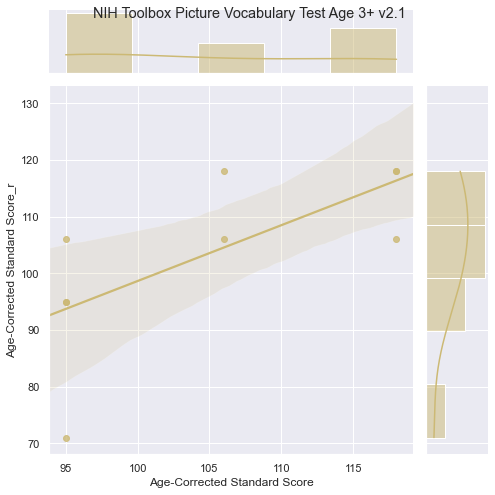

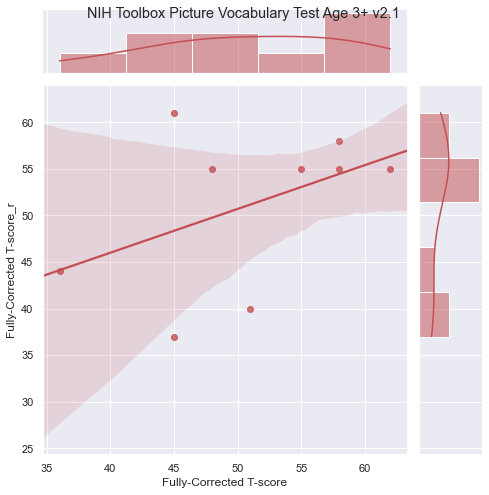

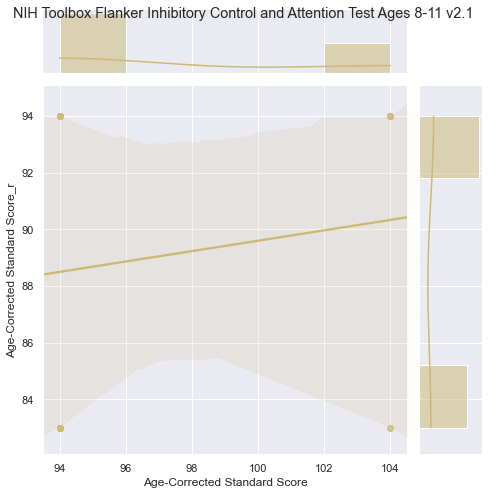

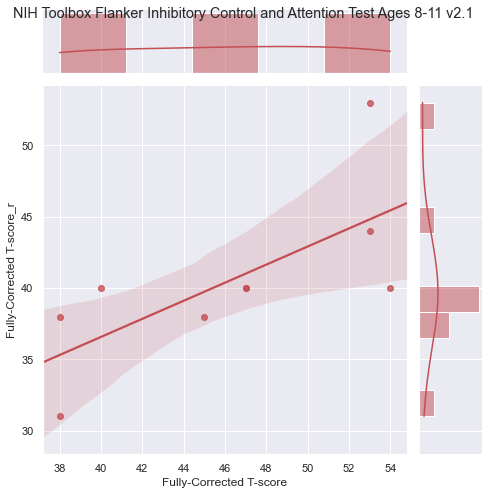

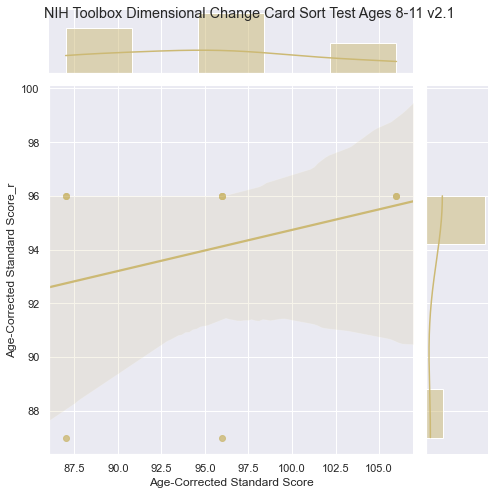

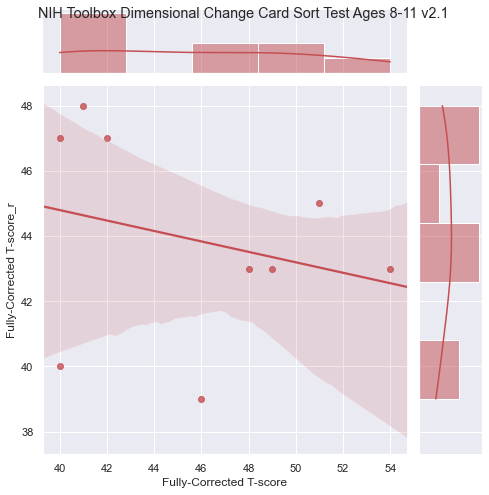

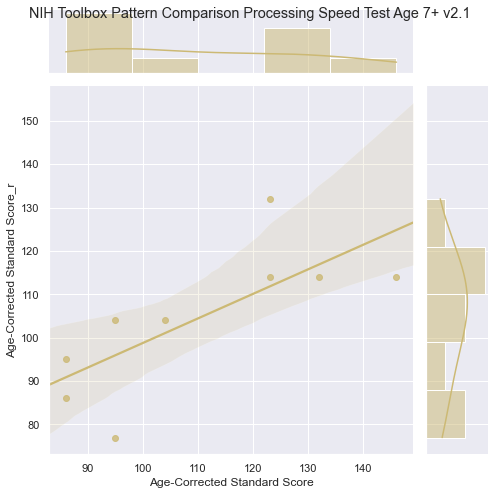

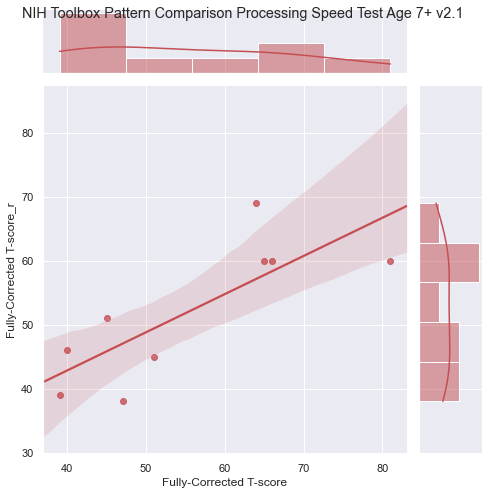

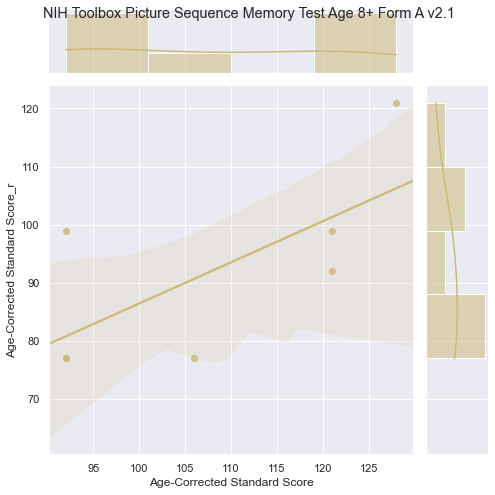

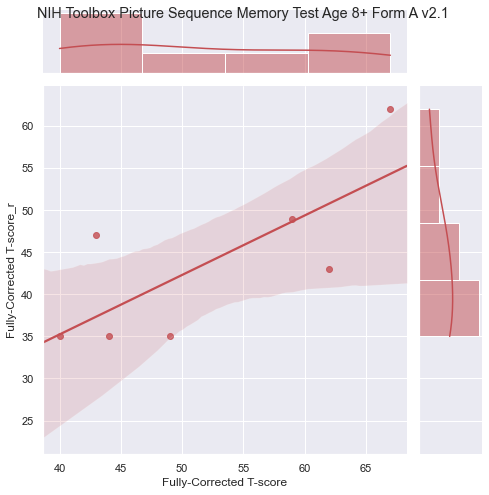

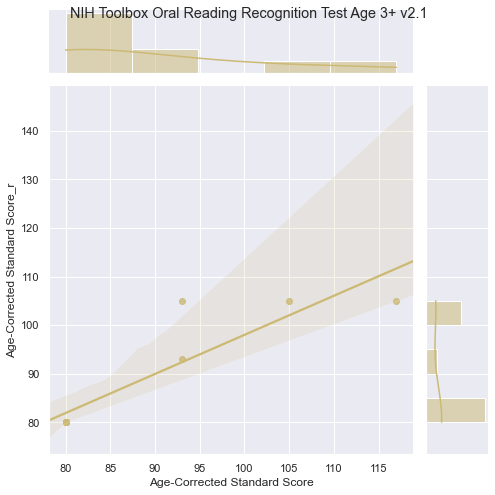

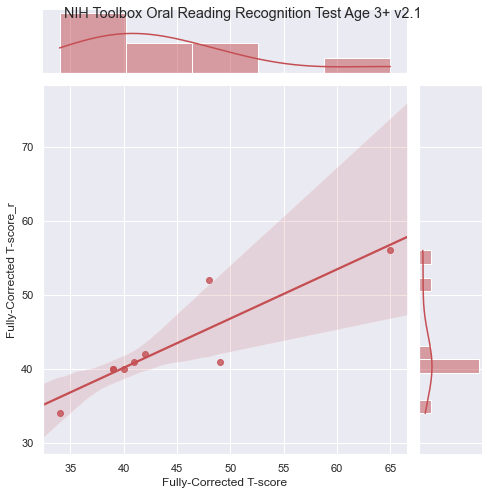

In [108]:
matched_ttest(NIH)

# 5.	A student’s t-test for everyone 

In [114]:
def remove_nan(li):
    array1 = np.array(li)

    nan_array = np.isnan(array1)
    not_nan_array = ~ nan_array
    array2 = array1[not_nan_array]

    return array2

In [115]:
def unmatched_ttest(ip, rm):
    if ip.Inst.nunique() < rm.Inst.nunique():
        match = list(ip.Inst.unique())
    else:
        match = list(rm.Inst.unique())
    
    for minst in match:
        print(minst)
        a =np.array(ip.set_index('Inst').filter(like=minst, axis=0)['Age-Corrected Standard Score'])
        b =np.array(rm.set_index('Inst').filter(like=minst, axis=0)['Age-Corrected Standard Score_r'])
        c =np.array(ip.set_index('Inst').filter(like=minst, axis=0)['Fully-Corrected T-score'])
        d =np.array(rm.set_index('Inst').filter(like=minst, axis=0)['Fully-Corrected T-score_r'])
        
        a=remove_nan(a)
        b=remove_nan(b)
        c= remove_nan(c)
        d= remove_nan(d)
        if(len(a)*len(b)*len(c)*len(d))==0:
            continue

        print('Aged: t-statistic = %6.3f, pvalue = %6.4f' % stats.ttest_ind(a,b, equal_var=False))
        print('Fully: t-statistic = %6.3f, pvalue = %6.4f' % stats.ttest_ind(c,d, equal_var=False))
        print('')
    return 

In [116]:
unmatched_ttest(raw, raw_r)

NIH Toolbox Picture Vocabulary Test Age 3+ v2.1
Aged: t-statistic =  0.780, pvalue = 0.4437
Fully: t-statistic = -0.603, pvalue = 0.5516

NIH Toolbox Flanker Inhibitory Control and Attention Test Ages 8-11 v2.1
Aged: t-statistic =  3.280, pvalue = 0.0031
Fully: t-statistic =  2.404, pvalue = 0.0236

NIH Toolbox List Sorting Working Memory Test Age 7+ v2.1
NIH Toolbox Dimensional Change Card Sort Test Ages 8-11 v2.1
Aged: t-statistic =  0.357, pvalue = 0.7244
Fully: t-statistic =  0.068, pvalue = 0.9463

NIH Toolbox Pattern Comparison Processing Speed Test Age 7+ v2.1
Aged: t-statistic =  0.895, pvalue = 0.3794
Fully: t-statistic =  0.504, pvalue = 0.6189

NIH Toolbox Picture Sequence Memory Test Age 8+ Form A v2.1
Aged: t-statistic =  1.258, pvalue = 0.2226
Fully: t-statistic =  0.453, pvalue = 0.6559

NIH Toolbox Oral Reading Recognition Test Age 3+ v2.1
Aged: t-statistic = -0.577, pvalue = 0.5697
Fully: t-statistic = -0.952, pvalue = 0.3509



# Composite Scores

# 1.	A matched t-test for those who have both in-person and remote 

# 2.	Correlations between remote and in-person

# 3.	Does it take longer for remote vs. in-person? 

# 4.	Plot on x-axis remote scores for all the Inst, and plot on y-axis all the in-person 

In [117]:
import seaborn as sns
sns.set_theme(style="darkgrid")

--- Cognition Crystallized Composite v1.1 ---
1. matched t-test:
Aged: t-statistic =  0.113, pvalue = 0.9118
Fully: t-statistic =  0.057, pvalue = 0.9551

2. Correlations between in person and remote:
Aged: correlation =  0.846, pvalue = 0.0041
Fully: correlation =  0.748, pvalue = 0.0206

3. Does it take longer for remote vs. in-person? two-sided test
Aged: t-statistic =  9.000 pvalue = 0.7389
Fully: t-statistic = 16.500 pvalue = 0.8328




C:\Users\TEMP\Anaconda3\lib\site-packages\scipy\stats\morestats.py:2967: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Users\TEMP\Anaconda3\lib\site-packages\scipy\stats\morestats.py:2981: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")



--- Cognition Early Childhood Composite v1.1 ---
1. matched t-test:
Aged: t-statistic =  2.256, pvalue = 0.0458
Fully: t-statistic =  2.083, pvalue = 0.0607

2. Correlations between in person and remote:
Aged: correlation =  0.597, pvalue = 0.1572
Fully: correlation =  0.696, pvalue = 0.0825

3. Does it take longer for remote vs. in-person? two-sided test
Aged: t-statistic =  1.000 pvalue = 0.0312
Fully: t-statistic =  0.000 pvalue = 0.0156





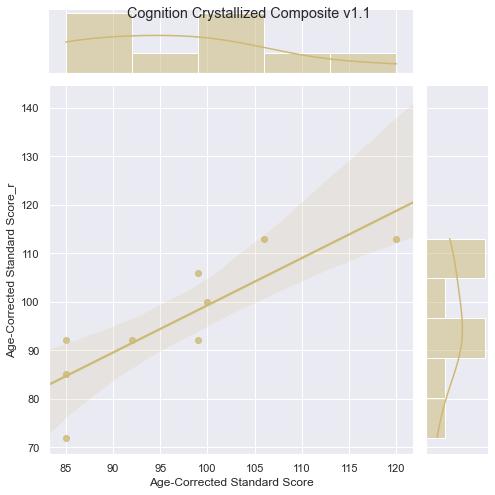

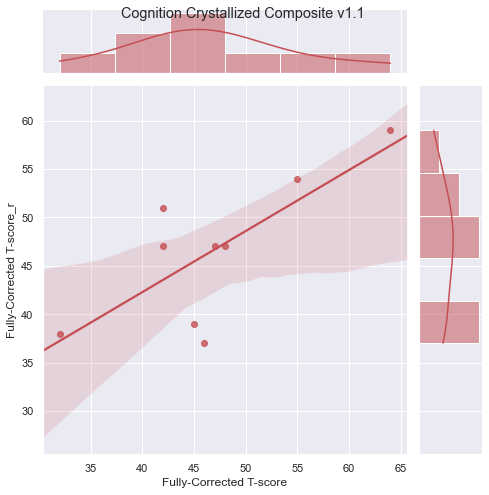

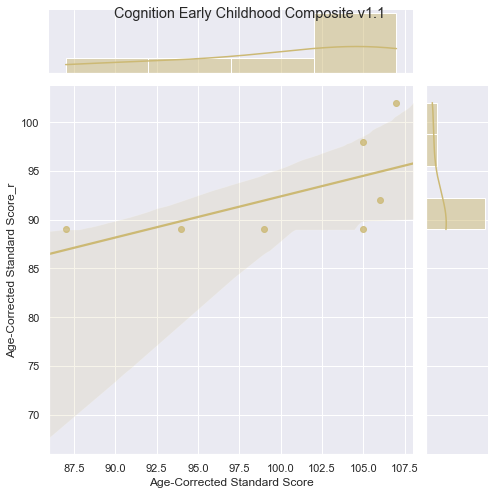

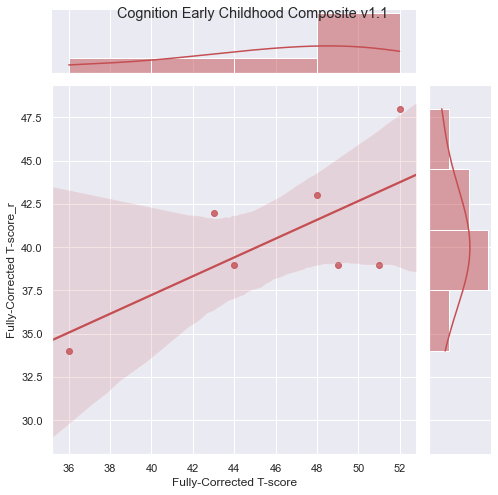

In [118]:
matched_ttest(scores)

In [119]:
boxp.tail()

,PIN,Inst,Uncorrected Standard Score,Age-Corrected Standard Score,National Percentile (age adjusted),Fully-Corrected T-score,Mode
7,EPSF_00944,CECC,77.0,89.0,24.0,39.0,Remote
6,EPSF_00836,CCC,74.0,92.0,31.0,53.0,Remote
7,EPSF_00836,CECC,75.0,86.0,17.0,47.0,Remote
6,EPSF_00836,CCC,74.0,92.0,31.0,53.0,Remote
7,EPSF_00836,CECC,75.0,86.0,17.0,47.0,Remote


In [120]:
boxp["Inst"].replace({"Cognition Fluid Composite v1.1":'CFC','Cognition Crystallized Composite v1.1':'CCC', 'Cognition Total Composite Score v1.1':'CTC','Cognition Early Childhood Composite v1.1':'CECC'}, inplace=True)

Text(0.5, 1.0, 'Age-Corrected Standard score')

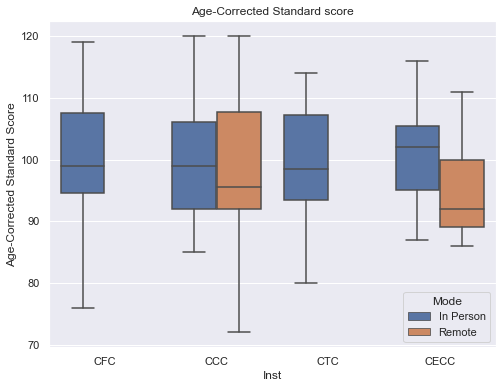

In [121]:
plt.figure(figsize=(8, 6))
sns.boxplot(x = 'Inst', y = 'Age-Corrected Standard Score', hue='Mode',data = boxp)
plt.title('Age-Corrected Standard score')

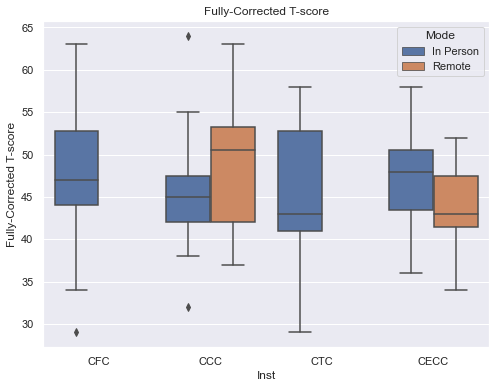

In [122]:
# Box plot of Fully In person vs. Remote
plt.figure(figsize=(8, 6))
sns.boxplot(x = 'Inst', y = 'Fully-Corrected T-score', hue='Mode',data = boxp)
plt.title('Fully-Corrected T-score')
plt.show()

# 5.	A student’s t-test for everyone 

In [123]:
unmatched_ttest(comp, comp_r)

Cognition Crystallized Composite v1.1
Aged: t-statistic =  0.029, pvalue = 0.9774
Fully: t-statistic = -1.070, pvalue = 0.2959

Cognition Early Childhood Composite v1.1
Aged: t-statistic =  1.969, pvalue = 0.0620
Fully: t-statistic =  1.028, pvalue = 0.3149



# Wide to Long

In [ ]:
all = pd.concat([df,dfr]) 

In [ ]:
time_breakdown.head()

In [ ]:
rv =pd.merge(time_breakdown, all, how='outer',on=['PIN','Inst','Mode'])

In [ ]:
rv.shape

In [ ]:
rv['Site'] = np.where(rv['PIN'].str.contains('SF'), 'Sioux Falls', 'Rapid City')

In [ ]:
all.head()

In [ ]:
rv = rv.melt(id_vars=['PIN','Inst','Mode','Date','Time','Site'], 
        var_name="Scores", 
        value_name="Value")

In [ ]:
rv=rv.dropna(thresh=6, axis=0)

In [ ]:
rv.shape

In [ ]:
rv.to_csv('C:/Users/TEMP/Box/Avera NIHTB Data/long_format_data.csv', index=False)